# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes("pastel")
sns.set_style("whitegrid")
%matplotlib inline

from pyspark.sql import SparkSession, Window

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import avg, col, concat, count, desc, asc, explode, lit, split, stddev, udf, isnan, when, rank, from_unixtime

from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [4]:
# Read in full sparkify dataset
event_data = "mini_sparkify_event_data.json"
df = spark.read.json(event_data)

In [5]:
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [7]:
# Statistics of the artist column
df.describe('artist').show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [8]:
# Statistics of the sessionId column
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [9]:
# Total Row
df.count()

286500

In [10]:
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [11]:
def count_missing(df, col):
    """
    A helper function which count how many missing values in a colum of the dataset.
    
    This function is useful because the data can be either three cases below:
    
    1. NaN
    2. Null
    3. "" (empty string)
    """
    return df.filter((isnan(df[col])) | (df[col].isNull()) | (df[col] == "")).count()

In [12]:
print("[missing values]\n")
for col in df.columns:
    missing_count = count_missing(df, col)
    if missing_count > 0:
        print("{}: {}".format(col, missing_count))

[missing values]

artist: 58392
firstName: 8346
gender: 8346
lastName: 8346
length: 58392
location: 8346
registration: 8346
song: 58392
userAgent: 8346
userId: 8346


In [13]:
df_without_missing_id = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_without_missing_id = df_without_missing_id.filter(df["userId"] != "") # `userId` should not be empty string

In [14]:
print("df:                    {}".format(df.count()))
print("df_without_missing_id: {}".format(df_without_missing_id.count())) # no missing values

if df.count() == df_without_missing_id.count():
    print("No missing values with userId and sessionId")
else:
    print("{} rows have been removed.".format(df.count() - df_without_missing_id.count()))

df:                    286500
df_without_missing_id: 278154
8346 rows have been removed.


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [15]:
# Detect number columns and category columns.

# num_cols: Number columns (Long or Double)
# cat_cols: Category columns (String)
    
num_cols = []
cat_cols = []

for s in df.schema:
    data_type = str(s.dataType)
    if data_type == "StringType":
        cat_cols.append(s.name)
    
    if data_type == "LongType" or data_type == "DoubleType":
        num_cols.append(s.name)

In [16]:
num_cols

['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']

In [17]:
cat_cols

['artist',
 'auth',
 'firstName',
 'gender',
 'lastName',
 'level',
 'location',
 'method',
 'page',
 'song',
 'userAgent',
 'userId']

In [18]:
df_without_missing_id.describe(num_cols).show()

+-------+------------------+-----------------+--------------------+------------------+------------------+--------------------+
|summary|     itemInSession|           length|        registration|         sessionId|            status|                  ts|
+-------+------------------+-----------------+--------------------+------------------+------------------+--------------------+
|  count|            278154|           228108|              278154|            278154|            278154|              278154|
|   mean|114.89918174824018|249.1171819778458|1.535358834084427...|1042.5616241362698|209.10321620397335|1.540958915431871...|
| stddev|  129.851729399489|99.23517921058361| 3.291321616327586E9| 726.5010362219813|30.151388851328214|1.5068287123306298E9|
|    min|                 0|          0.78322|       1521380675000|                 1|               200|       1538352117000|
|    max|              1321|       3024.66567|       1543247354000|              2474|               404|      

In [19]:
df_without_missing_id.select("status").dropDuplicates().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [20]:
df_without_missing_id.select("auth").dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [21]:
df_without_missing_id.select("gender").dropDuplicates().show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



In [22]:
df_without_missing_id.select("level").dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [23]:
df_without_missing_id.select("location").dropDuplicates().show(10)

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
+--------------------+
only showing top 10 rows



In [24]:
df_without_missing_id.select("method").dropDuplicates().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [25]:
df_without_missing_id.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [26]:
df_without_missing_id.select("userAgent").dropDuplicates().show(10)

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Maci...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 10 rows



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

Churn will be defined as when Cancellation Confirmation events happen, and users with the events are churned users in this analysis.

churn: Cancellation Confirmation

In [27]:
df_without_missing_id.filter("page = 'Cancellation Confirmation'").show(10)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  nu

In [28]:
flag_churned_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_churned = df_without_missing_id.withColumn("churned", flag_churned_event("page"))

In [29]:
churned_rate = df_churned.groupby("userId").agg({"churned": "sum"}).select(avg("sum(churned)")).collect()[0]["avg(sum(churned))"]
print("churned: {:.2f}%".format(churned_rate * 100))

churned: 23.11%


In [30]:
df_churned.select(["userId", "gender", "level", "page", "status", "ts", "churned"]).show(30)

+------+------+-----+---------------+------+-------------+-------+
|userId|gender|level|           page|status|           ts|churned|
+------+------+-----+---------------+------+-------------+-------+
|    30|     M| paid|       NextSong|   200|1538352117000|      0|
|     9|     M| free|       NextSong|   200|1538352180000|      0|
|    30|     M| paid|       NextSong|   200|1538352394000|      0|
|     9|     M| free|       NextSong|   200|1538352416000|      0|
|    30|     M| paid|       NextSong|   200|1538352676000|      0|
|     9|     M| free|       NextSong|   200|1538352678000|      0|
|     9|     M| free|       NextSong|   200|1538352886000|      0|
|    30|     M| paid|       NextSong|   200|1538352899000|      0|
|    30|     M| paid|Add to Playlist|   200|1538352905000|      0|
|    30|     M| paid|       NextSong|   200|1538353084000|      0|
|     9|     M| free|       NextSong|   200|1538353146000|      0|
|     9|     M| free|    Roll Advert|   200|1538353150000|    

In [31]:
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df_phase = df_churned.withColumn("phase", Fsum('churned').over(windowval))
df_churn = df_phase.withColumn("churn", Fmax('churned').over(Window.partitionBy("userId")))

In [32]:
df_churn.select(["userId", "gender", "level", "page", "status", "ts", "churned", "phase", "churn"]).show(20)

+------+------+-----+-----------+------+-------------+-------+-----+-----+
|userId|gender|level|       page|status|           ts|churned|phase|churn|
+------+------+-----+-----------+------+-------------+-------+-----+-----+
|100010|     F| free|   NextSong|   200|1539003534000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539003736000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539003932000|      0|    0|    0|
|100010|     F| free|  Thumbs Up|   307|1539003933000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539004195000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539004511000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539004694000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539004918000|      0|    0|    0|
|100010|     F| free|Roll Advert|   200|1539004961000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539005157000|      0|    0|    0|
|100010|     F| free|   N

In [33]:
df_churn.filter(df_churn["churn"] == 1).select(["userId", "gender", "level", "page", "status", "ts", "churned", "phase", "churn"]).show(20)

+------+------+-----+--------------------+------+-------------+-------+-----+-----+
|userId|gender|level|                page|status|           ts|churned|phase|churn|
+------+------+-----+--------------------+------+-------------+-------+-----+-----+
|   125|     M| free|            NextSong|   200|1539317144000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539317481000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539317711000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539317914000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539318124000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539318515000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539318728000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539318906000|      0|    0|    1|
|   125|     M| free|         Roll Advert|   200|1539318917000|      0|    0

In [34]:
churned_user_count = df_churn.filter(df_churn["churn"] == 1).select("userId").dropDuplicates().count()
print("churned user count: {} (total: {})".format(churned_user_count, df_churn.count()))
print("churned user rate: {:.2f}%".format(churned_user_count / df_churn.count() * 100))

churned user count: 52 (total: 278154)
churned user rate: 0.02%


### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.


The below columns will be examined:

artist
[x] the number of artist

gender: 0 or 1

length
[x] the total length

level: 0 or 1

page
[x] the number of Thumbs Up
[x] the number of Thumbs Down

song
[x] the number of song

Define a common function to convert churn value (0 or 1) to Not Churn or Churn

Both matplotlib and seaborn plot libraries require pandas dataframe, not pyspark dataframe, so I need to convert the pyspark dataframe to pandas one. I do this conversion every time for a small subset of the dataset because if I do this conversion for all the dataset, it takes time and causes an error.

In [35]:
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

In [36]:
df_churn_user = df_churn.groupby("userId").max("churn").withColumnRenamed("max(churn)", "churn").select(["userId", "churn"])

In [37]:
pd_gender = df_churn.select(["userId", "gender", "churn"]).withColumn("churn", func_churn_label("churn")).toPandas()
pd_gender.head()

,userId,gender,churn
0,100010,F,Not Churn
1,100010,F,Not Churn
2,100010,F,Not Churn
3,100010,F,Not Churn
4,100010,F,Not Churn


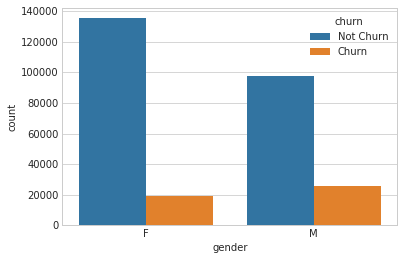

In [38]:
sns.countplot(x="gender", hue="churn", data=pd_gender);

In [39]:
pd_level = df_churn.select(["userId", "level", "churn"]).withColumn("churn", func_churn_label("churn")).toPandas()
pd_level.head()

,userId,level,churn
0,100010,free,Not Churn
1,100010,free,Not Churn
2,100010,free,Not Churn
3,100010,free,Not Churn
4,100010,free,Not Churn


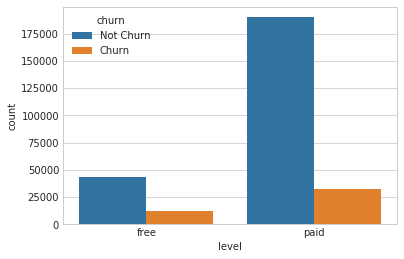

In [40]:
sns.countplot(x="level", hue="churn", data=pd_level);

In [41]:
pd_artist = df_churn_user.join(df_churn.groupby("userId") \
                                    .agg({"artist": "count"}) \
                                    .withColumnRenamed("count(artist)", "artist_count"), ["userId"]) \
                         .withColumn("churn", func_churn_label("churn")).toPandas()
pd_artist.head()

,userId,churn,artist_count
0,100010,Not Churn,275
1,200002,Not Churn,387
2,125,Churn,8
3,124,Not Churn,4079
4,51,Churn,2111


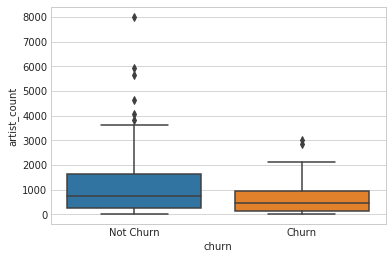

In [42]:
sns.boxplot(x="churn", y="artist_count", data=pd_artist);

In [43]:
pd_song = df_churn_user.join(df_churn.groupby("userId") \
                                     .agg({"song": "count"}) \
                                     .withColumnRenamed("count(song)", "song_count"), ["userId"]) \
                       .withColumn("churn", func_churn_label("churn")).toPandas()
pd_song.head()

,userId,churn,song_count
0,100010,Not Churn,275
1,200002,Not Churn,387
2,125,Churn,8
3,124,Not Churn,4079
4,51,Churn,2111


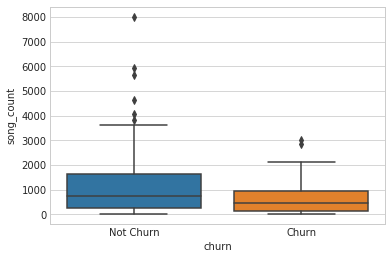

In [44]:
sns.boxplot(x="churn", y="song_count", data=pd_song);

In [45]:
pd_length = df_churn_user.join(df_churn.groupby("userId") \
                                       .agg({"length": "sum"}) \
                                       .withColumnRenamed("sum(length)", "total_length"), ["userId"]) \
                          .withColumn("churn", func_churn_label("churn")).toPandas()
pd_length.head()

,userId,churn,total_length
0,100010,Not Churn,6.694090e+04
1,200002,Not Churn,9.400888e+04
2,125,Churn,2.089113e+03
3,124,Not Churn,1.012312e+06
4,51,Churn,5.232758e+05


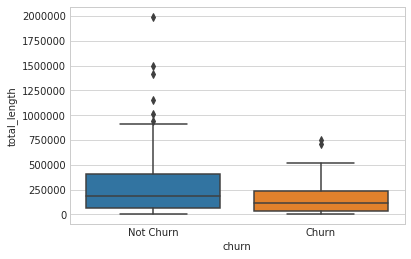

In [46]:
sns.boxplot(x="churn", y="total_length", data=pd_length);

In [47]:
pd_visit = df_churn_user.join(df_churn.groupby("userId") \
                                      .count() \
                                      .withColumnRenamed("count", "visit_count"), ["userId"]) \
                         .withColumn("churn", func_churn_label("churn")).toPandas()
pd_visit.head()

,userId,churn,visit_count
0,100010,Not Churn,381
1,200002,Not Churn,474
2,125,Churn,11
3,124,Not Churn,4825
4,51,Churn,2464


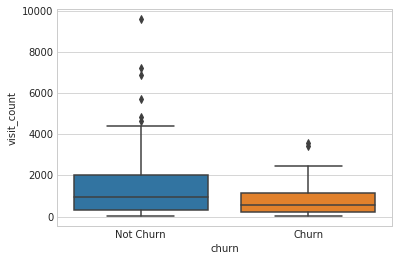

In [48]:
sns.boxplot(x="churn", y="visit_count", data=pd_visit);

In [49]:
pd_up = df_churn_user.join(df_churn.filter((df_churn["page"] == 'Thumbs Up')) \
                                   .groupby("userId") \
                                   .count() \
                                   .withColumnRenamed("count", "up_count"), ["userId"]) \
                     .withColumn("churn", func_churn_label("churn")).toPandas()
pd_up.head()

,userId,churn,up_count
0,100010,Not Churn,17
1,200002,Not Churn,21
2,124,Not Churn,171
3,51,Churn,100
4,7,Not Churn,7


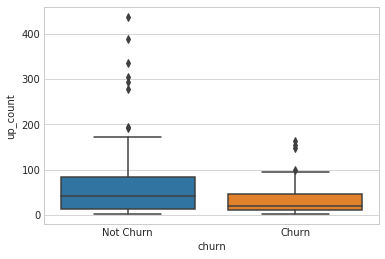

In [50]:
sns.boxplot(x="churn", y="up_count", data=pd_up);

In [51]:
pd_down = df_churn_user.join(df_churn.filter((df_churn["page"] == 'Thumbs Down')) \
                                   .groupby("userId") \
                                   .count() \
                                   .withColumnRenamed("count", "down_count"), ["userId"]) \
                     .withColumn("churn", func_churn_label("churn")).toPandas()
pd_down.head()

,userId,churn,down_count
0,100010,Not Churn,5
1,200002,Not Churn,6
2,124,Not Churn,41
3,51,Churn,21
4,7,Not Churn,1


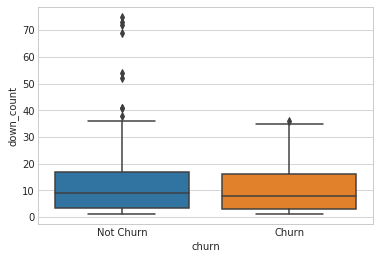

In [52]:
sns.boxplot(x="churn", y="down_count", data=pd_down);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [54]:
df_original = df_churn.groupby('userId').max("churn").withColumnRenamed("max(churn)", "target")

In [55]:
user_artist = df_churn.groupby("userId").agg({"artist": "count"}).withColumnRenamed("count(artist)", "artist_count")
user_artist.show(5)

+------+------------+
|userId|artist_count|
+------+------------+
|100010|         275|
|200002|         387|
|   125|           8|
|    51|        2111|
|   124|        4079|
+------+------------+
only showing top 5 rows



In [56]:
flag_gender = udf(lambda x: 1 if x == "F" else 0, IntegerType())
df_churn_with_gender = df_churn.withColumn("gender", flag_gender("gender"))

In [57]:
user_gender = df_churn_with_gender.groupby('userId').agg({"gender": "max"}).withColumnRenamed("max(gender)", "gender")
user_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|100010|     1|
|200002|     0|
|   125|     0|
|    51|     0|
|   124|     1|
+------+------+
only showing top 5 rows



In [58]:
user_length = df_churn.groupby('userId').agg({"length": "sum"}).withColumnRenamed("sum(length)", "length")

In [59]:
user_length.show(5)

+------+------------------+
|userId|            length|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
+------+------------------+
only showing top 5 rows



In [60]:
user_thumbs_up = df_churn.filter(df_churn["page"] == 'Thumbs Up').groupby('userId').count().withColumnRenamed("count", "thumb_up")
user_thumbs_up.show(5)

+------+--------+
|userId|thumb_up|
+------+--------+
|100010|      17|
|200002|      21|
|    51|     100|
|   124|     171|
|     7|       7|
+------+--------+
only showing top 5 rows



In [61]:
user_thumbs_down = df_churn.filter(df_churn["page"] == 'Thumbs Down').groupby('userId').count().withColumnRenamed("count", "thumb_down")
user_thumbs_down.show(5)

+------+----------+
|userId|thumb_down|
+------+----------+
|100010|         5|
|200002|         6|
|    51|        21|
|   124|        41|
|     7|         1|
+------+----------+
only showing top 5 rows



In [62]:
flag_level = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
df_churn_with_level = df_churn.withColumn("level", flag_level("level"))

In [63]:
user_level = df_churn_with_level.groupby('userId').agg({"level": "max"}).withColumnRenamed("max(level)", "level")
user_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|100010|    0|
|200002|    1|
|   125|    0|
|    51|    1|
|   124|    1|
+------+-----+
only showing top 5 rows



In [64]:
user_song = df_churn.groupby("userId").agg({"song": "count"}).withColumnRenamed("count(song)", "song_count")
user_song.show(5)

+------+----------+
|userId|song_count|
+------+----------+
|100010|       275|
|200002|       387|
|   125|         8|
|    51|      2111|
|   124|      4079|
+------+----------+
only showing top 5 rows



In [65]:
merged_df = df_original.join(user_artist, ['userId']) \
    .join(user_gender, ['userId']) \
    .join(user_length, ['userId']) \
    .join(user_level, ['userId']) \
    .join(user_thumbs_up, ['userId']) \
    .join(user_thumbs_down, ['userId']) \
    .join(user_song, ['userId'])

In [66]:
merged_df.show(5)

+------+------+------------+------+------------------+-----+--------+----------+----------+
|userId|target|artist_count|gender|            length|level|thumb_up|thumb_down|song_count|
+------+------+------------+------+------------------+-----+--------+----------+----------+
|100010|     0|         275|     1| 66940.89735000003|    0|      17|         5|       275|
|200002|     0|         387|     0| 94008.87593999993|    1|      21|         6|       387|
|   124|     0|        4079|     1|1012312.0927899999|    1|     171|        41|      4079|
|    51|     1|        2111|     0| 523275.8428000004|    1|     100|        21|      2111|
|     7|     0|         150|     0| 38034.08710000002|    0|       7|         1|       150|
+------+------+------------+------+------------------+-----+--------+----------+----------+
only showing top 5 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.


In this modeling section, the below tasks will be executed to build models. 

Three machine learning models will be examined and I will decide one of them based on the evaluation results for further hypyer parameter tuning.

1.scaling 

2.train/test split

3.build models

    -Logistic Regression
    
    -Random Forest classifier
    
    -GBT classifier
  
4.evaluate the models based on f1 score since churned users in the dataset are fairly small so the distribution of target variables are extremely biased.

Drop userId column (which is not necessary for modeling)

In [67]:
merged_df_without_user = merged_df.drop("userId")
feature_columns = [col for col in merged_df_without_user.columns if col!='target']
feature_columns

['artist_count',
 'gender',
 'length',
 'level',
 'thumb_up',
 'thumb_down',
 'song_count']

In [68]:
# Split

train, test = merged_df_without_user.randomSplit([0.7, 0.3], seed=0)

In [69]:
# Build Model

def build_model(classifier, param):
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator=MulticlassClassificationEvaluator(labelCol='target', metricName='f1'),
        numFolds=5,
    )
    return model

### Logistic Regression

In [70]:
lr = LogisticRegression(featuresCol="scaled_features", labelCol="target")
param = ParamGridBuilder().build()
model = build_model(lr, param)

In [72]:
%%time
fit_model = model.fit(train)

CPU times: user 9.45 s, sys: 2.05 s, total: 11.5 s
Wall time: 13min 58s


In [73]:
pred = fit_model.transform(test)

In [74]:
pred.select("prediction").dropDuplicates().collect()

[Row(prediction=0.0)]

In [75]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="target")
f1_score = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
print("f1: {}".format(f1_score))

f1: 0.7324641460234681


### Random Forest

In [77]:
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="target")
rf_param = ParamGridBuilder().build()
rf_model = build_model(rf, rf_param)

In [78]:
%%time
rf_fit_model = rf_model.fit(train)

CPU times: user 2.97 s, sys: 641 ms, total: 3.62 s
Wall time: 8min 38s


In [79]:
rf_pred = rf_fit_model.transform(test)

In [80]:
rf_pred.select("prediction").dropDuplicates().collect()

[Row(prediction=0.0), Row(prediction=1.0)]

In [81]:
rf_f1_score = evaluator.evaluate(rf_pred, {evaluator.metricName: "f1"})
print("f1: {}".format(rf_f1_score))

f1: 0.7383265856950068


### GBT

In [84]:
gbt =GBTClassifier(featuresCol="scaled_features", labelCol="target")
gbt_param = ParamGridBuilder().build()
gbt_model = build_model(gbt, gbt_param)

In [85]:
%%time
gbt_fit_model = gbt_model.fit(train)

CPU times: user 26.3 s, sys: 6.11 s, total: 32.4 s
Wall time: 35min 59s


In [86]:
gbt_pred = gbt_fit_model.transform(test)

In [87]:
gbt_pred.select("prediction").dropDuplicates().collect()

[Row(prediction=0.0), Row(prediction=1.0)]

In [88]:
gbt_f1_score = evaluator.evaluate(gbt_pred, {evaluator.metricName: "f1"})
print("f1: {}".format(gbt_f1_score))

f1: 0.7215309200603317


### Feature Importance

Random Forest gives me a better result than that of GBT classifier. 

In [89]:
rf_feature_importance_df = pd.DataFrame()
rf_feature_importance_df['feature'] = feature_columns
rf_feature_importance_df['importance'] = rf_fit_model.bestModel.stages[2].featureImportances.values.tolist()
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
rf_feature_importance_df

,feature,importance
0,artist_count,0.256960
1,thumb_up,0.220131
2,thumb_down,0.211686
3,song_count,0.108108
4,length,0.102071
5,gender,0.073467
6,level,0.027577


According to the feature importances provided by the Random Forest model, Thumbs Up and Thumbs Down seem to be important while the level of the users do not really matter.